In [1]:
import json
import csv

import sys
sys.path.append("../../")
#sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

torch.set_default_tensor_type(torch.DoubleTensor)

import imodal as dm
from imodal.HamiltonianDynamic import Hamiltonian, shoot
from imodal.MultiShape import MultiShapeHamiltonian

dm.Utilities.set_compute_backend('keops')
#dm.Utilities.set_compute_backend('torch')


In [2]:
import pykeops
#pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_torch_bindings()  


pyKeOps with torch bindings is working!



In [3]:
sys.version

'3.6.9 (default, Dec  8 2021, 21:08:43) \n[GCC 8.4.0]'

In [4]:
print(torch.__version__)

1.3.0


In [5]:
from PIL import Image
path_image = '/home/gris/Data/Multishape/'
source = torch.tensor(np.asarray(Image.open(path_image + "Lung_Moving.tif")))
target = torch.tensor(np.asarray(Image.open(path_image + "Lung_Fixed.tif")))

# load boundaries from csv file
from numpy import loadtxt
boundary0_pix = torch.tensor(loadtxt('boundary0.csv', delimiter=',')).t()#.flip(dims=[0])
boundary1_pix = torch.tensor(loadtxt('boundary1.csv', delimiter=',')).t()#.flip(dims=[0])


In [6]:
# convert the rgb image to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

source_tot = torch.tensor(rgb2gray(source))
target_tot = torch.tensor(rgb2gray(target))

In [7]:
source.shape, target.shape

(torch.Size([400, 400, 3]), torch.Size([404, 408, 3]))

In [8]:
# cropping the target so source and target are of the same size
target_tot = target_tot[2:-2, 4:-4]
target_tot.shape

torch.Size([400, 400])

In [9]:
step=5
source = source_tot[::step, ::step]
target = target_tot[::step, ::step]

In [10]:
source.shape

torch.Size([80, 80])

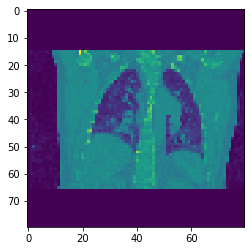

In [11]:
plt.imshow(source)# - target)

In [12]:
source_deformable_tot = dm.Models.DeformableImage(source_tot, backward=False, extent='match')
target_deformable_tot = dm.Models.DeformableImage(target_tot, backward=False, extent='match')
source_deformable = dm.Models.DeformableImage(source, backward=False, extent='match')
target_deformable = dm.Models.DeformableImage(target, backward=False, extent='match')

In [13]:
boundary0_pts = dm.Utilities.pixels2points(boundary0_pix, source_deformable_tot.shape, source_deformable_tot.extent)
boundary1_pts = dm.Utilities.pixels2points(boundary1_pix, source_deformable_tot.shape, source_deformable_tot.extent)

boundary0_pts = torch.load(path_image + 'curve_boundary0')
boundary1_pts = torch.load(path_image + 'curve_boundary1')

#rescale boundaries:
boundary0_pts[:,0] = boundary0_pts[:,0]*source_deformable.extent.xmax
boundary0_pts[:,1] = boundary0_pts[:,1]*source_deformable.extent.ymax
boundary1_pts[:,0] = boundary1_pts[:,0]*source_deformable.extent.xmax
boundary1_pts[:,1] = boundary1_pts[:,1]*source_deformable.extent.ymax

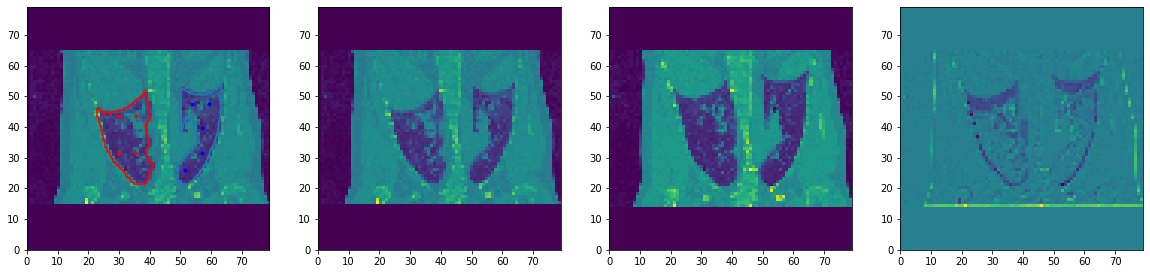

In [14]:
gd0 = torch.tensor([[0.38, 0.55], [0.45, 0.55], [0.38, 0.4], [0.45, 0.4]])
gd1 = torch.tensor([[0.65, 0.33], [0.72, 0.4], [0.72, 0.5], [0.68, 0.6], [0.75, 0.6]])
gd0[:,0] = gd0[:,0]*source_deformable.extent.xmax
gd0[:,1] = gd0[:,1]*source_deformable.extent.ymax
gd1[:,0] = gd1[:,0]*source_deformable.extent.xmax
gd1[:,1] = gd1[:,1]*source_deformable.extent.ymax

plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
plt.plot(boundary0_pts[:,0], boundary0_pts[:,1], '-r')
plt.plot(boundary1_pts[:,0], boundary1_pts[:,1], '-')
plt.plot(gd0[:,0], gd0[:,1], '.r')
plt.plot(gd1[:,0], gd1[:,1], '.b')
#plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
#plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(target_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
#plt.colorbar()


plt.subplot(1, 4, 4)
plt.imshow(target_deformable.geometry[0]-source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())

#plt.colorbar()

plt.show()

In [15]:
scale_translation = 20.
translation0 = dm.DeformationModules.Translations(2, gd0.shape[0], scale_translation, gd=gd0, cotan = 0.*torch.ones_like(gd0))
#scale_translation = 5.
translation1 = dm.DeformationModules.Translations(2, gd1.shape[0], scale_translation, gd=gd1, cotan = 0.*torch.ones_like(gd1))

In [16]:
attach = dm.Attachment.L2NormAttachment(transform=None)

In [17]:
shoot_solver = 'torch_euler'
shoot_it = 10

In [18]:
sigma_bck = 10.

In [19]:
boundary0 = dm.MultiShape.Boundary(copy.copy(boundary0_pts[::25]))
boundary1 = dm.MultiShape.Boundary(copy.copy(boundary1_pts[::25]))
boundary0.geometry[0].shape

torch.Size([22, 2])

In [20]:
constraints0 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0,torch.prod(torch.tensor(boundary0.geometry[0].shape)))#, compound_man)
constraints1 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1,torch.prod(torch.tensor(boundary1.geometry[0].shape)))#, compound_man)
constraints = dm.Constraints.Constraints.CompoundConstraints([constraints0, constraints1])


In [21]:
model = dm.Models.RegistrationModelMultishape([boundary0, boundary1], [source_deformable], [[translation0], [translation1]], [attach], sigma_bck, lam=10., constraints=constraints, backgroundtype='dense')

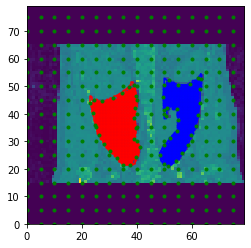

In [22]:
pts0 = model.modules[0].manifold[0].gd.detach()
pts1 = model.modules[1].manifold[0].gd.detach()
pts2 = model.modules[2].manifold[0].gd.detach()

plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
plt.plot(boundary0_pts[:,0], boundary0_pts[:,1], '-r')
plt.plot(boundary1_pts[:,0], boundary1_pts[:,1], '-b')
plt.plot(pts0[:,0], pts0[:,1], '.r')
plt.plot(pts1[:,0], pts1[:,1], '.b')
plt.plot(pts2[:,0], pts2[:,1], '.g')

In [23]:
shoot_solver = 'torch_euler'
shoot_it = 10

In [ ]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable], 20, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})

In [ ]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable], 20, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})

Compiling libKeOpstorchf81347bbe5 in /home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorchf81347bbe5:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction(Exp(-S*SqNorm2(x - y)/IntCst(2))*p,0), Var(2,2,1), Var(4,2,0), Var(5,2,0)), Var(0,2,0), Var(6,2,1), Var(7,2,1))
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,2); S = Pm(3,1); Var(4,2,0); Var(5,2,0); Var(6,2,1); Var(7,2,1); 
       dtype  : float64
... Done.
Compiling libKeOpstorchc3621e8eeb in /home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorchc3621e8eeb:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction(Exp(-S*SqNorm2(x - y)/IntCst(2))*p,0), Var(2,2,1), Var(4,2,0), Var(5,2,0)), Var(1,2,1), Var(6,2,1), Var(7,2,1))
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,2); S = Pm(3,1); Var(4,2,0); Var(5,2,0); Var(6,2,1); Var(7,2,1); 
       dtype  : float64
... Done.
Compiling libKeOpstorchae5529331b in /home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorchae5529331b:

... Done.
Compiling libKeOpstorch6076eafc8d in /home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorch6076eafc8d:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction(Exp(-S*SqNorm2(x - y)/IntCst(2))*p,0), Var(0,2,0), Var(4,2,0), Var(5,2,0)), Var(2,2,1), Var(6,2,0), Var(7,2,0))
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,2); S = Pm(3,1); Var(4,2,0); Var(5,2,0); Var(6,2,0); Var(7,2,0); 
       dtype  : float64
... Done.
Compiling libKeOpstorchbb5e69ca85 in /home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorchbb5e69ca85:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction(Exp(-S*SqNorm2(x - y)/IntCst(2))*p,0), Var(0,2,0), Var(4,2,0), Var(5,2,0)), Var(4,2,0), Var(6,2,0), Var(7,2,0))
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,2); S = Pm(3,1); Var(4,2,0); Var(5,2,0); Var(6,2,0); Var(7,2,0); 
       dtype  : float64
... Done.
Compiling libKeOpstorch3206ed1311 in /home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorch3

... Done.
Compiling libKeOpstorch3a455515cf in /home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorch3a455515cf:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction((Exp(-S*SqNorm2(x - y)/IntCst(2))*px | py)/IntCst(2),1), Var(0,2,0), Var(5,1,1), Var(6,1,1)), Var(2,2,0), Var(7,2,0), Var(8,2,0))
       aliases: x = Vi(0,2); y = Vj(1,2); px = Vi(2,2); py = Vj(3,2); S = Pm(4,1); Var(5,1,1); Var(6,1,1); Var(7,2,0); Var(8,2,0); 
       dtype  : float64
... Done.
Compiling libKeOpstorchc683cf0937 in /home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorchc683cf0937:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction((Exp(-S*SqNorm2(x - y)/IntCst(2))*px | py)/IntCst(2),1), Var(0,2,0), Var(5,1,1), Var(6,1,1)), Var(3,2,1), Var(7,2,0), Var(8,2,0))
       aliases: x = Vi(0,2); y = Vj(1,2); px = Vi(2,2); py = Vj(3,2); S = Pm(4,1); Var(5,1,1); Var(6,1,1); Var(7,2,0); Var(8,2,0); 
       dtype  : float64
... Done.


In [25]:
#with torch.autograd.no_grad():
intermediates = {}
model.deformables[0].output = 'bitmap'
deformed = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

deformed_image = deformed[0][0].view_as(source)


In [26]:
boundary0 = model.modules[0].manifold.gd[-1].detach()
boundary1 = model.modules[1].manifold.gd[-1].detach()

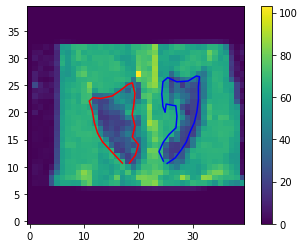

In [27]:
pts0 = model.modules[0].manifold[0].gd.detach()
pts1 = model.modules[1].manifold[0].gd.detach()
pts2 = model.modules[2].manifold[0].gd.detach()

plt.imshow(deformed_image.detach(), origin='lower')
plt.plot(boundary0[:,0], boundary0[:,1], '-r')
plt.plot(boundary1[:,0], boundary1[:,1], '-b')
plt.colorbar()
#plt.plot(pts0[:,0], pts0[:,1], '.r')
#plt.plot(pts1[:,0], pts1[:,1], '.b')
#plt.plot(pts2[:,0], pts2[:,1], '.g')

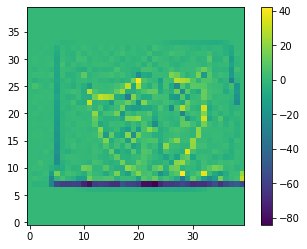

In [28]:
plt.imshow(source.detach() - deformed_image.detach(), origin='lower')
plt.colorbar()

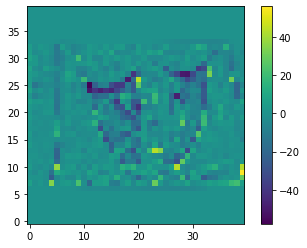

In [29]:
plt.imshow(target_deformable.geometry[0] - deformed_image.detach(), origin='lower')
plt.colorbar()

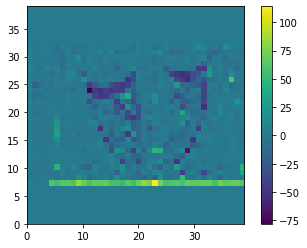

In [30]:
plt.imshow(target_deformable.geometry[0]-source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())

plt.colorbar()

In [37]:
a = [[0, 1], [2, 3, 4]]
c = [b for b in a]
c = [d for b in a for d in b]

print(c)

[0, 1, 2, 3, 4]


In [35]:
isinstance(c[0], list)

False

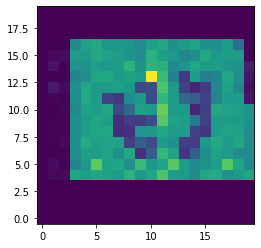

In [60]:
plt.imshow(source_deformable._to_deformed(source_deformable.silent_module.manifold.gd)[0], origin='lower')

In [97]:
index0 = 0
index1 = 1
def fun(cot):
    cotan = model.init_manifold.cotan
    cotan[index0][index1] = cot
    multishape = MultiShape.MultiShapeModules(model.modules, sigma_bck, 'dense')

    multishape.manifold.fill_gd(model.init_manifold.gd, requires_grad=True)
    multishape.manifold.fill_cotan(cotan, requires_grad=True)



    deformables = [source_deformable]

    silent_modules = [multishape.modules[i][0] for i in range(len(deformables))]
    #modules_tot = [[*silent, *mod] for silent, mod in zip(silent_modules, multishape.modules)]

    #multi_shape_tot = MultiShape(modules_tot, multishape.sigma_background)
    Ham = MultiShapeHamiltonian.Hamiltonian_multishape(multishape, constraints)
    Ham.geodesic_controls()
    intermediates = {}
    shoot(Ham, shoot_solver, shoot_it)
    
    backward_module = deformables[0]._backward_module()
    grid_pts = backward_module.manifold.gd
    grid_pts_deformed = torch.empty([labels.shape[0], backward_module.dim])
    for i, mod in enumerate(multishape.modules[:-1]):
        grid_pts_deformed[labels==i] = mod[0].manifold.gd

    i = len(multishape.modules) -1

    grid_pts_deformed[labels==i] = multishape.modules[i][-1].manifold.gd  
    gridpts_defo_vec = grid_pts_deformed.unsqueeze(2)

    normdiff = torch.sum( (gridpts_defo_vec -grid_pts.unsqueeze(0).transpose(1,2))**2, dim=1)

    _, ind_nearest = torch.topk(normdiff, k=1, dim=1, largest=False)

    labels_grid = labels[ind_nearest].view(-1)

    mod_list = []
    for i, mod in enumerate(multishape.modules[:-1]):
        pt = grid_pts[labels_grid==i].contiguous()
        #mod_list.append(CompoundModule([silent_modules[i], SilentLandmarks(2, pt.shape[0], gd=pt.clone()), *mod.modules[1:]]))
        mod_list.append(CompoundModule([mod.modules[0], SilentLandmarks(2, pt.shape[0], gd=pt.clone()), *mod.modules[1:]]))

    i = len(multishape.modules) -1
    pt = grid_pts[labels_grid==i].contiguous()    
    mod_list.append(CompoundModule([*multishape.modules[-1].modules, SilentLandmarks(2, pt.shape[0], gd=pt.clone())]))

    # Reverse the moments for backward shooting
    [compound.manifold.negate_cotan() for compound in mod_list]
    multishape_bk = MultiShape.MultiShapeModules(mod_list, multishape.sigma_background, multishape.backgroundtype)

    #TODO constraints must be independent from manifold
    Ham = MultiShapeHamiltonian.Hamiltonian_multishape(multishape_bk, constraints)
    Ham.geodesic_controls()
    # Backward shooting
    shoot(Ham, shoot_solver, shoot_it)

    grid_pts_deformed_bk = torch.empty([labels.shape[0], backward_module.dim])
    for i, mod in enumerate(multishape_bk.modules[:-1]):
        grid_pts_deformed_bk[labels==i] = mod[1].manifold.gd

    i = len(multishape_bk.modules) -1
    grid_pts_deformed_bk[labels==i] = multishape_bk.modules[-1].modules[-1].manifold.gd
    deformed = deformables[0]._to_deformed(grid_pts_deformed_bk)
    #return deformed
    return attach(deformed[0], target_deformable.geometry)
    #return torch.sum(multishape_bk.manifold.manifolds[0][0].gd) + torch.sum(multishape_bk.manifold.manifolds[1][0].gd) + torch.sum(multishape_bk.manifold.manifolds[2][0].gd)
    #return torch.sum(multishape_bk[0][1].controls) + torch.sum(multishape_bk[1][1].controls) + torch.sum(multishape_bk[2][0].controls)
    #return torch.sum(grid_pts_deformed_bk)
    #return torch.sum(multishape.manifold.manifolds[0][0].gd) + torch.sum(multishape.manifold.manifolds[1][0].gd) + torch.sum(multishape.manifold.manifolds[2][0].gd)
    #return torch.sum(intermediates[-1][0][0].gd) + torch.sum(intermediates[-1][1][0].gd) + torch.sum(intermediates[-1][2][0].gd)
    #return torch.sum(multishape[0][1].controls) + torch.sum(multishape[1][1].controls) + torch.sum(multishape[2][0].controls)
    

In [98]:
torch.autograd.gradcheck(fun, cotan[index0][index1], raise_exception=True)

True

In [95]:
fun(cotan[0][0]).backward()

KeyboardInterrupt: 

In [78]:
cotan[0][0].grad

tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2

In [69]:

def fun(cotan):
    #cotan = model.init_manifold.cotan
    #cotan[0] = cot
    multishape = MultiShape.MultiShapeModules(model.modules, sigma_bck, 'dense')

    multishape.manifold.fill_gd(model.init_manifold.gd, requires_grad=True)
    multishape.manifold.fill_cotan(cotan, requires_grad=True)


    return torch.sum(cotan[0][0])
    #return deformed
    #return attach(deformed[0], target_deformable.geometry)
    #return torch.sum(multishape_bk.manifold.manifolds[0][0].gd) + torch.sum(multishape_bk.manifold.manifolds[1][0].gd) + torch.sum(multishape_bk.manifold.manifolds[2][0].gd)
    #return torch.sum(multishape_bk[0][1].controls) + torch.sum(multishape_bk[1][1].controls) + torch.sum(multishape_bk[2][0].controls)
    #return torch.sum(grid_pts_deformed_bk)
    #return torch.sum(multishape.manifold.manifolds[0][0].gd) + torch.sum(multishape.manifold.manifolds[1][0].gd) + torch.sum(multishape.manifold.manifolds[2][0].gd)
    #return torch.sum(intermediates[-1][0][0].gd) + torch.sum(intermediates[-1][1][0].gd) + torch.sum(intermediates[-1][2][0].gd)
    #return torch.sum(multishape[0][1].controls) + torch.sum(multishape[1][1].controls) + torch.sum(multishape[2][0].controls)
    

In [79]:
torch.autograd.gradcheck(fun, cotan, raise_exception=True)

ValueError: gradcheck expects at least one input tensor to require gradient, but none of the them have requires_grad=True.

In [90]:
def f(x):
    return torch.sum(x[0]**2) + torch.sum(x[1]**2)

In [91]:
x= [torch.ones(3, requires_grad=True), torch.ones(3, requires_grad=True)]

In [93]:
torch.autograd.gradcheck(f, (x), raise_exception=True)

TypeError: f() takes 1 positional argument but 2 were given

In [50]:
cotan[0][2].grad

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [47]:
fun(cotan).backward()

In [51]:
attach(source_deformable.geometry, target_deformable.geometry)

tensor(337441.5016)

In [62]:
multishape_bk[2][-1].manifold.gd.shape

torch.Size([668, 2])

In [63]:
grid_pts_deformed_bk[labels==2].shape

torch.Size([668, 2])

In [28]:
    multishape = MultiShape.MultiShapeModules(model.modules, sigma_bck, 'dense')

    multishape.manifold.fill_gd(model.init_manifold.gd)
    multishape.manifold.fill_cotan(model.init_manifold.cotan)




In [48]:
multishape[2][1].manifold.gd.shape

torch.Size([668, 2])

In [49]:
sum(labels==2)

tensor(668)

In [40]:
gds = [mod[0].manifold.gd for mod in multishape[:-1]]
gds.append(multishape[-1][1].manifold.gd)
dim = gds[0].shape[1]
[gd.requires_grad_() for gd in gds]

[tensor([[0.4231, 0.3077],
         [0.4615, 0.3077],
         [0.5000, 0.3077],
         [0.3846, 0.3462],
         [0.4231, 0.3462],
         [0.4615, 0.3462],
         [0.5000, 0.3462],
         [0.3462, 0.3846],
         [0.3846, 0.3846],
         [0.4231, 0.3846],
         [0.4615, 0.3846],
         [0.3462, 0.4231],
         [0.3846, 0.4231],
         [0.4231, 0.4231],
         [0.4615, 0.4231],
         [0.3462, 0.4615],
         [0.3846, 0.4615],
         [0.4231, 0.4615],
         [0.4615, 0.4615],
         [0.3077, 0.5000],
         [0.3462, 0.5000],
         [0.3846, 0.5000],
         [0.4231, 0.5000],
         [0.4615, 0.5000],
         [0.3077, 0.5385],
         [0.3462, 0.5385],
         [0.3846, 0.5385],
         [0.4231, 0.5385],
         [0.4615, 0.5385],
         [0.4231, 0.5769],
         [0.4615, 0.5769],
         [0.5000, 0.5769],
         [0.4615, 0.6154]], requires_grad=True), tensor([[0.6538, 0.2692],
         [0.6538, 0.3077],
         [0.6923, 0.3077],
       

In [36]:
def fun(gds):
    grid_pts_deformed_bk = torch.empty([labels.shape[0], dim])
    for i, gd in enumerate(gds):
        grid_pts_deformed_bk[labels==i] = gd
    i = len(gds) - 1
    grid_pts_deformed_bk[labels==i] = gds[i]
    return torch.sum(grid_pts_deformed_bk)


In [46]:
fun(gds).backward()

In [47]:
gds[2].grad

tensor([[3., 3.],
        [3., 3.],
        [3., 3.],
        ...,
        [3., 3.],
        [3., 3.],
        [3., 3.]])

In [ ]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable], 40, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})

In [23]:
from pykeops.torch import Genred, KernelSolve

In [24]:
ty = model.modules[0].manifold.dtype
dev = model.modules[0].manifold.device
keops_dtype = str(model.modules[0].manifold[0].gd.dtype).split(".")[1]
dim = model.modules[0].manifold.dim
keops_invsigmasq = torch.tensor([1./sigma_bck/sigma_bck], dtype=ty, device=dev)

formula_cost = "(Exp(-S*SqNorm2(x - y)/IntCst(2))*px | py)/IntCst(2)"
alias_cost = ["x=Vi("+str(dim)+")", "y=Vj("+str(dim)+")", "px=Vi(" + str(dim)+")", "py=Vj("+str(dim)+")", "S=Pm(1)"]
reduction_cost = Genred(formula_cost, alias_cost, reduction_op='Sum', axis=0, dtype=keops_dtype)

formula_cgc = "Exp(-S*SqNorm2(x - y)/IntCst(2))*X"

alias_cgc = ["x=Vi("+str(dim)+")", "y=Vj("+str(dim)+")", "X=Vj("+str(dim) + ")", "S=Pm(1)"]

solve_cgc = KernelSolve(formula_cgc, alias_cgc, "X", axis=1, dtype=keops_dtype)


In [25]:
solve_cgc(self.manifold.gd, self.manifold.gd, vs, self.__keops_invsigmasq, backend=self.__keops_backend, alpha=0.)

NameError: name 'self' is not defined

In [30]:
keops_dtype

'float64'

In [32]:
model.modules[0].manifold.manifolds[-1].numel_gd

(44,)

In [ ]:
torch.zeros_like

In [26]:
isinstance(model.modules[0].modules[0], dm.DeformationModules.SilentLandmark.SilentBase)

True

In [27]:
model.labels.shape

torch.Size([100])

In [27]:
pts1.shape

torch.Size([3, 2])

In [28]:
pts2.shape

torch.Size([94, 2])

In [23]:
pts = source_deformable.extent.fill_uniform_density(density=1./(0.5*sigma_bck)**2)

In [25]:
pts_0 = boundary0.isin_extract(pts)

In [120]:
points = list(boundary0_pts.clone())
line0 = [points.pop(0)]

In [121]:
for i in range(len(points)):
    diff = [torch.sum((p - line0[i])**2) for p in points]
    indi = torch.argmin(torch.tensor(diff))
    line0.append(points.pop(indi))

In [ ]:
line0_ten = torch.stack(line0)

In [194]:
torch.save(line0_ten, path_image + 'curve_boundary0')

In [195]:
line0_ten_lo = torch.load(path_image + 'curve_boundary0')

In [198]:
points = list(boundary1_pts.clone())
line1 = [points.pop(0)]

In [199]:
for i in range(len(points)):
    diff = [torch.sum((p - line1[i])**2) for p in points]
    indi = torch.argmin(torch.tensor(diff))
    line1.append(points.pop(indi))

In [202]:
line1_ten = torch.stack(line1)
print(line1_ten.shape)

torch.Size([636, 2])


In [204]:
torch.save(line1_ten, path_image + 'curve_boundary1')

In [205]:
line1_ten_lo = torch.load(path_image + 'curve_boundary1')

In [206]:
line1_ten_lo - line1_ten

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

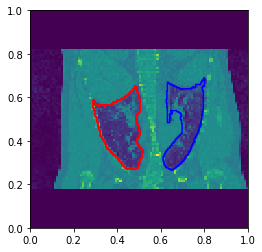

In [203]:
#init = 0
fin = 539
plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
plt.plot(line0_ten[init:fin,0], line0_ten[init:fin,1], '-r')
plt.plot(line0_ten_lo[init:fin,0], line0_ten_lo[init:fin,1], '-r')
init = 0
fin = 636
plt.plot(line1_ten[init:fin,0], line1_ten[init:fin,1], '-b')
#plt.plot(line1_ten_lo[init:fin,0], line1_ten_lo[init:fin,1], '-b')

In [102]:
diff = [torch.sum((p - line0[0])**2) for p in points]

In [103]:
line0[0]

tensor([0.4436, 0.2707])

In [104]:
diff[0]

tensor(6.2814e-06)

In [105]:
diff[18]

tensor(6.2814e-06)

In [108]:
diff

[tensor(6.2814e-06),
 tensor(2.5125e-05),
 tensor(5.6532e-05),
 tensor(0.0001),
 tensor(0.0002),
 tensor(0.0002),
 tensor(0.0003),
 tensor(0.0004),
 tensor(0.0005),
 tensor(0.0006),
 tensor(0.0008),
 tensor(0.0009),
 tensor(0.0011),
 tensor(0.0012),
 tensor(0.0014),
 tensor(0.0016),
 tensor(0.0018),
 tensor(0.0020),
 tensor(6.2814e-06),
 tensor(0.0020),
 tensor(8.1658e-05),
 tensor(5.0251e-05),
 tensor(3.1407e-05),
 tensor(2.5125e-05),
 tensor(0.0021),
 tensor(0.0023),
 tensor(0.0025),
 tensor(0.0028),
 tensor(0.0001),
 tensor(0.0028),
 tensor(0.0003),
 tensor(0.0002),
 tensor(0.0002),
 tensor(0.0029),
 tensor(0.0003),
 tensor(0.0029),
 tensor(0.0005),
 tensor(0.0005),
 tensor(0.0004),
 tensor(0.0030),
 tensor(0.0033),
 tensor(0.0006),
 tensor(0.0033),
 tensor(0.0008),
 tensor(0.0007),
 tensor(0.0034),
 tensor(0.0037),
 tensor(0.0009),
 tensor(0.0038),
 tensor(0.0013),
 tensor(0.0011),
 tensor(0.0010),
 tensor(0.0040),
 tensor(0.0014),
 tensor(0.0041),
 tensor(0.0018),
 tensor(0.0017),

In [107]:
torch.argmin(torch.tensor(diff))

tensor(18)

In [84]:
diff[245]

tensor(0.0565)

In [101]:
diff[0]

tensor(0.0025)

In [77]:
boundary0_pts.shape

torch.Size([540, 2])

In [75]:
len(points)

539

In [87]:
line0

tensor([0.4436, 0.2707])

In [88]:
points[0]

tensor([0.4461, 0.2707])

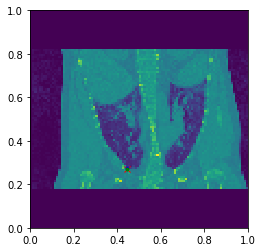

In [109]:
init = 0
fin = 1
plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
plt.plot(boundary0_pts[init:fin,0], boundary0_pts[init:fin,1], 'xr')
init = 19
fin = 20
plt.plot(boundary0_pts[init:fin,0], boundary0_pts[init:fin,1], '.b')
init = 1
fin = 2
plt.plot(boundary0_pts[init:fin,0], boundary0_pts[init:fin,1], '.g')

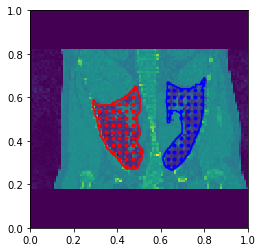

In [210]:

plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
#plt.plot(boundary0_pts[::1,0], boundary0_pts[::1,1], '-r')
plt.plot(line0_ten_lo[:,0], line0_ten_lo[:,1], '-r')
plt.plot(line1_ten_lo[:,0], line1_ten_lo[:,1], '-b')
#plt.plot(boundary1_pts[:,0], boundary1_pts[:,1], '.b')
#plt.plot(pts[:,0], pts[:,1], '.g')
#plt.plot(pts_0_closed[:,0], pts_0_closed[:,1], '.r')
plt.plot(points_inside0[:,0], points_inside0[:,1], '.r')
plt.plot(points_inside1[:,0], points_inside1[:,1], '.b')
#plt.plot(model.modules[0].manifold[0].gd[:,0], model.modules[0].manifold[0].gd[:,1], '.r')
#plt.plot(model.modules[1].manifold[0].gd[:,0], model.modules[1].manifold[0].gd[:,1], '.b')
#plt.plot(model.modules[2].manifold[0].gd[:,0], model.modules[2].manifold[0].gd[:,1], '.g')

In [207]:
points_inside0 = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, source_deformable.extent, 1000., shape=line0_ten_lo)
points_inside1 = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, source_deformable.extent, 1000., shape=line1_ten_lo)


In [47]:
boundary0_pts_closed.shape

torch.Size([541, 2])

In [33]:
boundary0_pts_closed = torch.cat([boundary0_pts, boundary0_pts[0].unsqueeze(0)])
boundary0_closed = dm.MultiShape.Boundary(copy.copy(boundary0_pts_closed))
pts_0_closed = boundary0.isin_extract(pts)

In [125]:
sil = source_deformable.silent_module
pts = sil.manifold.gd

In [130]:
#%matplotlib qt5
plt.imshow(source, extent=source_deformable.extent.totuple(), origin='lower')
plt.plot(boundary0_pts[:,0], boundary0_pts[:,1], '.')
plt.plot(pts[::10,0], pts[::10,1], '.')


In [15]:
pts.shape

torch.Size([1600, 2])

In [16]:
source.shape

torch.Size([40, 40])

In [17]:
boundary0 = dm.MultiShape.Boundary(boundary0_pts)
boundary1 = dm.MultiShape.Boundary(boundary1_pts)

#source_deformable = dm.Models.DeformableImage(source, extent='match')
#target_deformable = dm.Models.DeformableImage(target, extent='match')


In [18]:
deformables = [source_deformable]

In [19]:
isinstance(source_deformable, dm.Models.DeformableImage)

True

In [20]:
pts = torch.tensor([])

In [21]:
pts = torch.cat([pts,source_deformable.silent_module.manifold.gd.clone()])

In [40]:
a = pts[:5].unsqueeze(0).transpose(1,2)
b = pts[:7].unsqueeze(2)

In [41]:
a.shape

torch.Size([1, 2, 5])

In [42]:
b.shape

torch.Size([7, 2, 1])

In [43]:
(a-b).shape

torch.Size([7, 2, 5])

In [37]:
for i, p in enumerate(pts):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
ind = torch.zeros(3, dtype=int)

In [23]:
a=boundary0.isin_label(pts)

In [34]:
(a.view(-1,1)*pts)

AttributeError: 'Tensor' object has no attribute 'nonzeros'

In [27]:
indi = a.nonzero()

In [28]:
a[indi]

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [56]:
boundary0.silent_module.manifold.gd.shape

torch.Size([540, 2])

In [8]:

module0 = 
module1 = 
module_bg = 

#we need attachment terms which take into account the segmentation
attach0 = dm.Attachment.EuclideanPointwiseDistanceAttachment_mask()
attach1 = dm.Attachment.EuclideanPointwiseDistanceAttachment_mask()
attachBg = dm.Attachment.EuclideanPointwiseDistanceAttachment_mask()

shoot_solver = 'torch_euler'
shoot_it = 10

compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold(
    [dm.Manifolds.CompoundManifold([source_deformable.silent_module.manifold.clone(requires_grad=True), module0.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([source_deformable.silent_module.manifold.clone(requires_grad=True), module1.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([source_deformable.silent_module.manifold.clone(requires_grad=True), module_bg.manifold.clone(requires_grad=True), [boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]])])


SyntaxError: invalid syntax (<ipython-input-8-1b1121d61961>, line 7)

In [41]:
a = source -target
a = torch.mul(a, a)

In [42]:
a

tensor([[    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000, 52430.5123, 52430.5123,  ..., 52430.5123, 52430.5123,
             0.0000],
        [    0.0000, 52430.5123,     0.0000,  ...,     0.0000, 52430.5123,
             0.0000],
        ...,
        [    0.0000, 52430.5123,     0.0000,  ...,     0.0000, 52430.5123,
             0.0000],
        [    0.0000, 52430.5123, 52430.5123,  ..., 52430.5123, 52430.5123,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000]])

In [31]:
source.shape, a.shape

(torch.Size([400, 400]), torch.Size([]))

In [ ]:
_, ind_nearest = torch.topk(normdiff, k=2, dim=1, largest=False)

In [102]:
a = torch.randn([20, 2])
asq = a.unsqueeze(0).transpose(1,2)
b = torch.randn([4, 2])

(-1.385257852746902,
 1.4071639615413092,
 -1.5860953949811232,
 2.135042526115916)

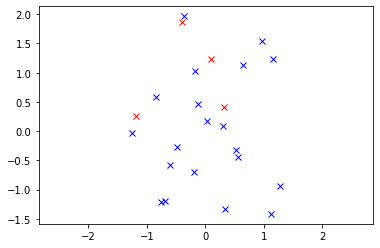

In [103]:
plt.plot(a[:,0], a[:,1], 'xb')
plt.plot(b[:,0], b[:,1], 'xr')
plt.axis('equal')

In [104]:
normdiff = torch.sum( (asq -b.unsqueeze(2))**2, dim=1)

In [105]:
normdiff.shape

torch.Size([4, 20])

In [106]:
_, ind_nearest = torch.topk(normdiff, k=2, dim=1, largest=False)

In [107]:
ind_nearest[:,]

tensor([[ 7, 14],
        [15,  3],
        [ 4,  7],
        [ 1, 11]])

In [108]:
diff_nearest = a[ind_nearest[:,1]] - a[ind_nearest[:,0]]
diff_pts = a[ind_nearest[:,0]] - b

In [144]:
ps = torch.sum(diff_nearest * diff_pts, dim=1)
no = torch.sum(diff_nearest * diff_nearest, dim=1)

ps.shape

t = - ps/no
t = t.unsqueeze(1)

proj = a[ind_nearest[:,0]] + t*diff_nearest

(-1.385257852746902,
 1.4071639615413092,
 -1.5860953949811232,
 2.135042526115916)

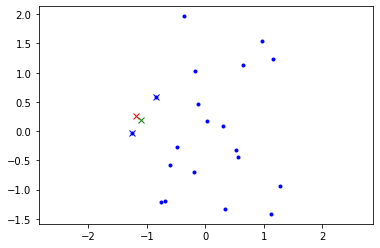

In [149]:
ind = 1
plt.plot(a[:,0], a[:,1], '.b')
plt.plot(a[ind_nearest[ind,0],0], a[ind_nearest[ind,0],1], 'xb')
plt.plot(a[ind_nearest[ind,1],0], a[ind_nearest[ind,1],1], 'xb')

plt.plot(b[ind,0], b[ind,1], 'xr')
ind
plt.plot(proj[ind,0], proj[ind,1], 'xg')
plt.axis('equal')

In [46]:
a[ind_nearest[:,0],0]

IndexError: index 3 is out of bounds for dimension 0 with size 3